In [1]:
!pip install cirq --quiet
!pip install qiskit --quiet

In [45]:
import numpy as np
import random
import time
import itertools as itert
import cirq
import matplotlib.pyplot as plt
import math
from qiskit import *
from qiskit.providers.jobstatus import JobStatus
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import MCMT
from qiskit.tools.monitor import job_monitor
%matplotlib inline

GROVER'S

Final implementation using CZ and X gates are below.

In [53]:
# Generate a random function for given n and a(num_ans)
def getFx(n, verbose, num_ans = 0):
    if num_ans == 0:
        num_ans = np.random.randint(low = 1, high = 2**n)

    if verbose:
        print('Number of x such that f(x) = 1: ', num_ans)

    binList = []
    randList = random.sample(range(0, 2**n), num_ans)
    for i in range(num_ans):
        x = randList[i]
        maxLength = len(bin(2**n-1)[2:])
        binary = (bin(x))[2:]  
        currLength = len(binary)
        ansBinary = '0' * (maxLength - currLength)
        ansBinary += binary

        if verbose:
            print(i + 1, 'th one is: ', ansBinary[::-1])

        binList.append(ansBinary)

    return randList

In [1]:
def createZ0(n):
    gate = np.zeros((2 ** n, 2 ** n), dtype=int)
    # since this is -Z0, set first element to 1 not -1
    gate[0][0] = 1
    # set all other elements on the diagonal to -1, again not 1 because this is -Z0
    for i in range(1, 2 ** n):
        gate[i][i] = -1
    # Return gate
    return Operator(gate)

def createZf(n, fnlist):
    # fnlist has all the x for which f(x) = 1
    gate = np.zeros((2 ** n, 2 ** n), dtype=int)
    # set diagonals of matrix based on f(x)
    for i in range(2 ** n):
        gate[i][i] = 1
    
    for element in fnlist:
        gate[element][element] = -1
        
    # create and return gate
    return Operator(gate)

def bitstring(bits):
    return "".join(str(int(b)) for b in bits)

def expectedProbability(n, num_ans, numIterations):
    N = 2 ** n
    theta = np.arcsin(np.sqrt(num_ans / N))
    prob_arr = np.sin((2*numIterations + 1) * theta ) ** 2

    return prob_arr * 100

def runMainCircuit(n = 0, num_ans = 1, verbose = True):
    # Taking the input n from the user
    if(n == 0):
        n = int(input("Enter length of function input: "))
    elif verbose:
        print('Input Length: ', n)
    
    # Number of Iterations
    numIterations = max(1, int(round(((np.pi/4) / math.asin(np.sqrt(num_ans / 2 ** n))) - 1/2)))
    if verbose:
        print("Number of iterations: ", numIterations)

    # Defining n qubits 
    qubits = QuantumRegister(n)
    registers = ClassicalRegister(n)
    
    rv_qr = list()
    for index in range(n):
        rv_qr.append(index)
    rv_qr.reverse()
    
    # Defining start of Cirq program
    c = QuantumCircuit(qubits, registers)

    # Choose a random function. Returns the list of values that have 1.
    randlist = getFx(n, verbose, num_ans)

    # Time taken by program needs to be checked.
    start = time.time()
    
    #Creating gates
    uf_zf = createZf(n, randlist)
    uf_z0 = createZ0(n)
    
    # adding Hadamard gates to all qubits
    for index in range(n):
        c.h(qubits[index])

    for k in range(0,numIterations):
        if verbose:
            print("Iteration no: ", k)
        c.unitary(uf_zf, rv_qr)
        for index in range(n):
            c.h(qubits[index])
        c.unitary(uf_z0, rv_qr)
        for index in range(n):
            c.h(qubits[index])
    
    # Adding measurement gates 
    c.measure(qubits[0:n], registers)
    
    mid = time.time()
    
    num_shots = 100
    simulator = Aer.get_backend('aer_simulator')
    circ = transpile(c, simulator)
    sim_results = simulator.run(circ, shots = num_shots).result()

    end = time.time()
    
    
    IBMQ.save_account('b5bbcda1a0eff0449582c42c04c3e1339b7d6af1ab309ffd16a8c573da617096454904a5983830ad7cfe7c2f554214b07ae5b642a9603d66dd91404a6cbb5db2')
    provider = IBMQ.load_account()

    backend = provider.backend.ibmq_quito
    transpiled = transpile(c, backend)
    job = backend.run(transpiled, shots = num_shots)

    result = backend.retrieve_job(job.job_id()).result()

    if verbose:
        print("Circuit used to solve problem: ")
        print(c)
        print("IBM Results: ")
        delayed_counts = result.get_counts()
        print(delayed_counts)
        plt.bar(delayed_counts.keys(), delayed_counts.values(), color='b')
        plt.show()

        frequencies = sim_results.get_counts(circ)
        print('Simulated results:\n{}'.format(frequencies))
        plt.bar(frequencies.keys(), frequencies.values(), color='r')
        plt.show()

        print("Expected Success Rate: ", expectedProbability(n, num_ans, numIterations), '%')

        print("Time taken to create circuit: ", mid - start)
        print("Time taken for simulation: ", end - mid)
        print("Time taken by execution: ", result.time_taken)

    return (mid - start, end - mid, result.time_taken)

Correctness Test Cases:

configrc.store_credentials:WARNING:2022-03-05 23:51:12,801: Credentials already present. Set overwrite=True to overwrite.


Input Length:  2
Number of iterations:  1
Number of x such that f(x) = 1:  1
1 th one is:  11
Iteration no:  0


ibmqfactory.load_account:WARNING:2022-03-05 23:51:13,466: Credentials are already in use. The existing account in the session will be replaced.


Circuit used to solve problem: 
        ┌───┐┌──────────┐┌───┐┌──────────┐┌───┐┌─┐   
q333_0: ┤ H ├┤1         ├┤ H ├┤1         ├┤ H ├┤M├───
        ├───┤│  Unitary │├───┤│  Unitary │├───┤└╥┘┌─┐
q333_1: ┤ H ├┤0         ├┤ H ├┤0         ├┤ H ├─╫─┤M├
        └───┘└──────────┘└───┘└──────────┘└───┘ ║ └╥┘
  c5: 2/════════════════════════════════════════╩══╩═
                                                0  1 
IBM Results: 
{'00': 2, '01': 2, '10': 5, '11': 91}


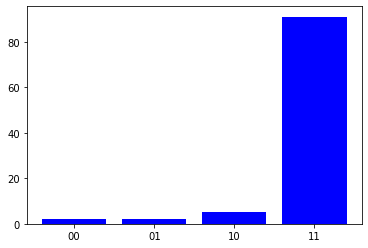

Simulated results:
{'11': 100}


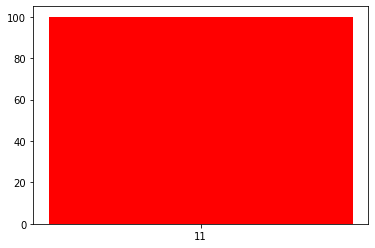

Expected Success Rate:  100.0 %
Time taken to create circuit:  0.0015039443969726562
Time taken for simulation:  0.0291290283203125
Time taken by execution:  2.4709270000457764


(0.0015039443969726562, 0.0291290283203125, 2.4709270000457764)

In [55]:
runMainCircuit(2, 1)

configrc.store_credentials:WARNING:2022-03-06 00:03:23,982: Credentials already present. Set overwrite=True to overwrite.


Input Length:  3
Number of iterations:  1
Number of x such that f(x) = 1:  2
1 th one is:  101
2 th one is:  110
Iteration no:  0


ibmqfactory.load_account:WARNING:2022-03-06 00:03:24,569: Credentials are already in use. The existing account in the session will be replaced.


Circuit used to solve problem: 
        ┌───┐┌──────────┐┌───┐┌──────────┐┌───┐┌─┐      
q368_0: ┤ H ├┤2         ├┤ H ├┤2         ├┤ H ├┤M├──────
        ├───┤│          │├───┤│          │├───┤└╥┘┌─┐   
q368_1: ┤ H ├┤1 Unitary ├┤ H ├┤1 Unitary ├┤ H ├─╫─┤M├───
        ├───┤│          │├───┤│          │├───┤ ║ └╥┘┌─┐
q368_2: ┤ H ├┤0         ├┤ H ├┤0         ├┤ H ├─╫──╫─┤M├
        └───┘└──────────┘└───┘└──────────┘└───┘ ║  ║ └╥┘
  c6: 3/════════════════════════════════════════╩══╩══╩═
                                                0  1  2 
IBM Results: 
{'000': 3, '001': 9, '010': 5, '011': 7, '100': 16, '101': 20, '110': 21, '111': 19}


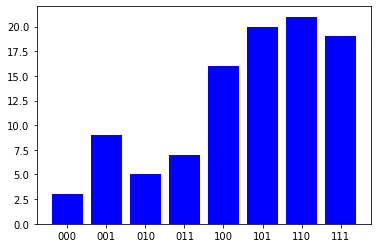

Simulated results:
{'101': 50, '110': 50}


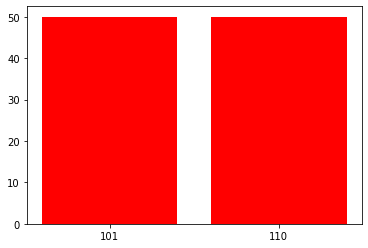

Expected Success Rate:  100.0 %
Time taken to create circuit:  0.001683950424194336
Time taken for simulation:  0.024838924407958984
Time taken by execution:  4.287785530090332


(0.001683950424194336, 0.024838924407958984, 4.287785530090332)

In [56]:
runMainCircuit(3, 2)

configrc.store_credentials:WARNING:2022-03-06 00:06:33,144: Credentials already present. Set overwrite=True to overwrite.


Input Length:  4
Number of iterations:  3
Number of x such that f(x) = 1:  1
1 th one is:  1100
Iteration no:  0
Iteration no:  1
Iteration no:  2


ibmqfactory.load_account:WARNING:2022-03-06 00:06:33,602: Credentials are already in use. The existing account in the session will be replaced.


Circuit used to solve problem: 
        ┌───┐┌──────────┐┌───┐┌──────────┐┌───┐┌──────────┐┌───┐┌──────────┐»
q446_0: ┤ H ├┤3         ├┤ H ├┤3         ├┤ H ├┤3         ├┤ H ├┤3         ├»
        ├───┤│          │├───┤│          │├───┤│          │├───┤│          │»
q446_1: ┤ H ├┤2         ├┤ H ├┤2         ├┤ H ├┤2         ├┤ H ├┤2         ├»
        ├───┤│  Unitary │├───┤│  Unitary │├───┤│  Unitary │├───┤│  Unitary │»
q446_2: ┤ H ├┤1         ├┤ H ├┤1         ├┤ H ├┤1         ├┤ H ├┤1         ├»
        ├───┤│          │├───┤│          │├───┤│          │├───┤│          │»
q446_3: ┤ H ├┤0         ├┤ H ├┤0         ├┤ H ├┤0         ├┤ H ├┤0         ├»
        └───┘└──────────┘└───┘└──────────┘└───┘└──────────┘└───┘└──────────┘»
  c7: 4/════════════════════════════════════════════════════════════════════»
                                                                            »
«        ┌───┐┌──────────┐┌───┐┌──────────┐┌───┐┌─┐         
«q446_0: ┤ H ├┤3         ├┤ H ├┤3         ├┤ H ├┤

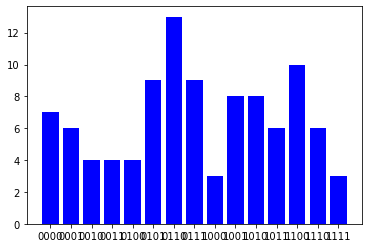

Simulated results:
{'0001': 1, '0000': 1, '1000': 1, '1100': 97}


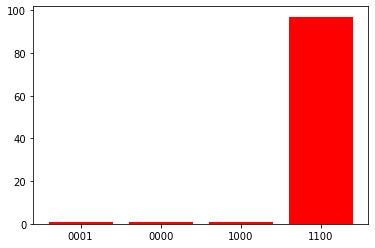

Expected Success Rate:  96.13189697265625 %
Time taken to create circuit:  0.003859996795654297
Time taken for simulation:  0.03473305702209473
Time taken by execution:  4.649252653121948


(0.003859996795654297, 0.03473305702209473, 4.649252653121948)

In [57]:
runMainCircuit(4, 1)

Time for various Zf for n = 5 and a = 1

configrc.store_credentials:WARNING:2022-03-06 08:32:09,119: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-06 08:32:09,738: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-06 08:45:14,569: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-06 08:45:15,502: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-06 08:52:03,742: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-06 08:52:04,362: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-06 09:05:53,724: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-06 09:05:54,345: Credentials are alread

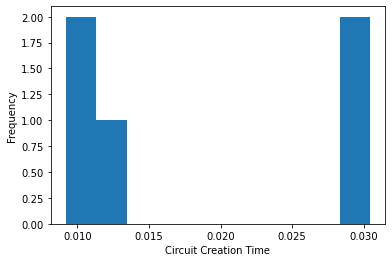

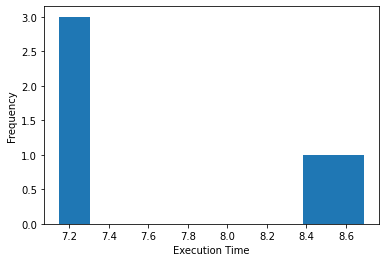

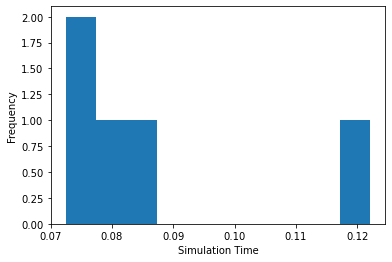

In [59]:
circuitTimes = []
simulationTimes = []
executionTimes = []
for i in range(5):
    (circuit, simulation, execution) = runMainCircuit(5, 1, False)
    circuitTimes.append(circuit)
    executionTimes.append(execution)
    simulationTimes.append(simulation)
plt.hist(circuitTimes)
plt.xlabel('Circuit Creation Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(executionTimes)
plt.xlabel('Execution Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(simulationTimes)
plt.xlabel('Simulation Time')
plt.ylabel('Frequency')
plt.show() 

Effect of a on execution time

configrc.store_credentials:WARNING:2022-03-06 09:30:31,083: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-06 09:30:31,800: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-06 09:40:53,762: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-06 09:40:54,606: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-06 09:53:44,074: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-06 09:53:44,663: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-06 10:05:54,494: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-06 10:05:55,001: Credentials are alread

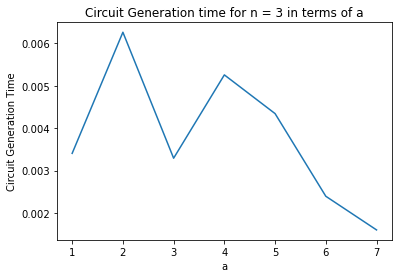

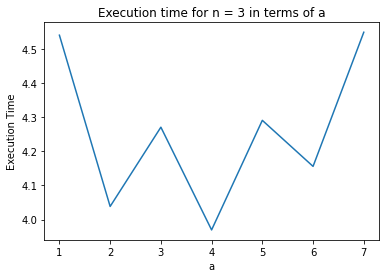

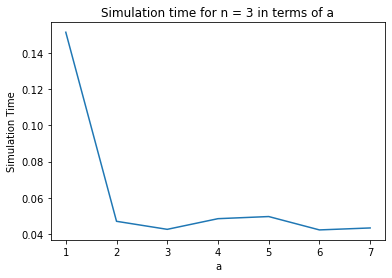

In [60]:
circuitTimes = []
executionTimes = []
simulationTimes = []
for a in range(1, 8):
    (circuit, simulation, execution) = runMainCircuit(3, a, False)
    circuitTimes.append(circuit)
    executionTimes.append(execution)
    simulationTimes.append(simulation)

x_axis = [1, 2, 3, 4, 5, 6, 7]
plt.plot(x_axis, circuitTimes)
plt.title('Circuit Generation time for n = 3 in terms of a')
plt.ylabel('Circuit Generation Time')
plt.xlabel('a')
plt.show() 

plt.plot(x_axis, executionTimes)
plt.title('Execution time for n = 3 in terms of a')
plt.ylabel('Execution Time')
plt.xlabel('a')
plt.show() 

plt.plot(x_axis, simulationTimes)
plt.title('Simulation time for n = 3 in terms of a')
plt.ylabel('Simulation Time')
plt.xlabel('a')
plt.show() 

Effect of n on execution time

configrc.store_credentials:WARNING:2022-03-06 12:26:21,454: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-06 12:26:22,246: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-06 13:18:40,728: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-06 13:18:41,425: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-06 13:31:58,739: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-06 13:31:59,356: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-06 13:41:08,403: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-06 13:41:08,983: Credentials are alread

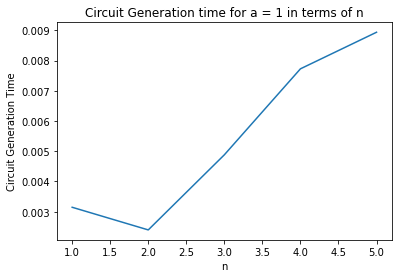

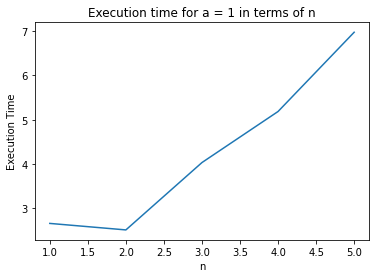

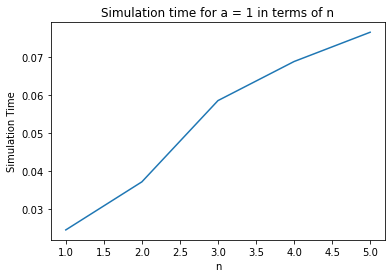

In [62]:
circuitTimes = []
executionTimes = []
simulationTimes = []

for n in range(1, 6):
    (circuit, simulation, execution) = runMainCircuit(n, 1, False)
    circuitTimes.append(circuit)
    executionTimes.append(execution)
    simulationTimes.append(simulation)

x_axis = [1, 2, 3, 4, 5]
plt.plot(x_axis, circuitTimes)
plt.title('Circuit Generation time for a = 1 in terms of n')
plt.ylabel('Circuit Generation Time')
plt.xlabel('n')
plt.show() 

plt.plot(x_axis, executionTimes)
plt.title('Execution time for a = 1 in terms of n')
plt.ylabel('Execution Time')
plt.xlabel('n')
plt.show() 

plt.plot(x_axis, simulationTimes)
plt.title('Simulation time for a = 1 in terms of n')
plt.ylabel('Simulation Time')
plt.xlabel('n')
plt.show() 